In [1]:
# Imports and defaults
import itertools
import joblib
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import block_diag
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import time

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 9
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)
print("%d joblib cores" % joblib.cpu_count())

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

python 3.6.8
matplotlib 3.2.2
46 joblib cores


In [2]:
# Bandit environments
class CoBandit(object):
  """Contextual bandit with K arms."""

  def __init__(self, K, contexts, Theta, sigma=1.0):
    self.K = K  # number of arms
    self.contexts = np.copy(contexts)  # [number of contexts] x d feature matrix
    self.num_contexts = self.contexts.shape[0]  # number of contexts
    self.d = self.contexts.shape[1]  # number of features
    self.Theta = np.copy(Theta)  # [number of arms] x d arm parameters
    self.sigma = sigma  # reward noise

    self.randomize()

  def randomize(self):
    # randomly choose one context per arm
    # this needs to be corrected to the same context for all arms
    ndx = np.random.randint(self.num_contexts, size=self.K)
    self.X = self.contexts[ndx, :]

    # mean and stochastic rewards
    self.mut = (self.X * self.Theta).sum(axis=-1)
    self.rt = self.mut + self.sigma * np.random.randn(self.K)
    self.best_arm = np.argmax(self.mut)

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mut[self.best_arm] - self.mut[arm]

  def print(self):
    return "Contextual bandit: %d dimensions, %d arms" % (self.d, self.K)


def evaluate_one(Alg, params, env, n, period_size=1):
  """One run of a bandit algorithm."""
  alg = Alg(env, n, params)

  regret = np.zeros(n // period_size)
  for t in range(n):
    # generate state
    env.randomize()

    # take action and update agent
    arm = alg.get_arm(t)
    alg.update(t, arm, env.reward(arm))

    # track performance
    regret_at_t = env.regret(arm)
    regret[t // period_size] += regret_at_t

  return regret, alg


def evaluate(Alg, params, env, n=1000, period_size=1, printout=True):
  """Multiple runs of a bandit algorithm."""
  if printout:
    print("Evaluating %s" % Alg.print(), end="")
  start = time.time()

  num_exps = len(env)
  regret = np.zeros((n // period_size, num_exps))
  alg = num_exps * [None]

  output = Parallel(n_jobs=-1)(delayed(evaluate_one)(Alg, params, env[ex], n, period_size)
    for ex in range(num_exps))
  for ex in range(num_exps):
    regret[:, ex] = output[ex][0]
    alg[ex] = output[ex][1]
  if printout:
    print(" %.1f seconds" % (time.time() - start))

  if printout:
    total_regret = regret.sum(axis=0)
    print("Regret: %.2f +/- %.2f (median: %.2f, max: %.2f, min: %.2f)" %
      (total_regret.mean(), total_regret.std() / np.sqrt(num_exps),
      np.median(total_regret), total_regret.max(), total_regret.min()))

  return regret, alg

In [3]:
# Bandit algorithms
class LinBanditAlg:
  def __init__(self, env, n, params):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.d = self.env.d  # number of features
    self.n = n  # horizon
    self.Theta0 = np.copy(env.mar_Theta0)  # prior means of arm parameters
    self.Sigma0 = np.copy(env.mar_Sigma0)  # prior covariance of arm parameters
    self.sigma = self.env.sigma  # reward noise

    # override default values
    for attr, val in params.items():
      if isinstance(val, np.ndarray):
        setattr(self, attr, np.copy(val))
      else:
        setattr(self, attr, val)

    self.Lambda0 = np.zeros((self.K, self.d, self.d))
    for i in range(self.K):
      self.Lambda0[i, :, :] = np.linalg.inv(self.Sigma0[i, :, :])

    # sufficient statistics
    self.G = np.zeros((self.K, self.d, self.d))
    self.B = np.zeros((self.K, self.d))

  def update(self, t, arm, r):
    # update sufficient statistics
    x = self.env.X[arm, :]
    self.G[arm, :, :] += np.outer(x, x) / np.square(self.sigma)
    self.B[arm, :] += x * r / np.square(self.sigma)


class LinTS(LinBanditAlg):
  def get_arm(self, t):
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # linear model posterior
      Gt = self.Lambda0[i, :, :] + self.G[i, :, :]
      Sigma_hat = np.linalg.inv(Gt)
      theta_hat = np.linalg.solve(Gt, self.Lambda0[i, :, :].dot(self.Theta0[i, :]) + self.B[i, :])
      
      # posterior sampling
      theta_tilde = np.random.multivariate_normal(theta_hat, Sigma_hat)
      self.mu[i] = self.env.X[i, :].dot(theta_tilde)
    
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "LinTS"


class LinUCB(LinBanditAlg):
  def __init__(self, env, n, params):
    LinBanditAlg.__init__(self, env, n, params)

    self.cew = self.confidence_ellipsoid_width(n)

  def confidence_ellipsoid_width(self, t):
    # Theorem 2 in Abassi-Yadkori (2011)
    # Improved Algorithms for Linear Stochastic Bandits
    delta = 1 / self.n
    L = np.amax(np.linalg.norm(self.env.contexts, axis=1))
    Lambda = np.trace(self.Lambda0, axis1=-2, axis2=-1).max() / self.d
    R = self.sigma
    S = np.sqrt(self.d)
    width = np.sqrt(Lambda) * S + \
      R * np.sqrt(self.d * np.log((1 + t * np.square(L) / Lambda) / delta))
    return width

  def get_arm(self, t):
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # linear model posterior
      Gt = self.Lambda0[i, :, :] + self.G[i, :, :]
      Sigma_hat = np.linalg.inv(Gt)
      theta_hat = np.linalg.solve(Gt, self.Lambda0[i, :, :].dot(self.Theta0[i, :]) + self.B[i, :])

      # UCBs
      Sigma_hat /= np.square(self.sigma)
      self.mu[i] = self.env.X[i, :].dot(theta_hat) + self.cew * \
        np.sqrt(self.env.X[i, :].dot(Sigma_hat).dot(self.env.X[i, :]))

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "LinUCB"


class meTS:
  def __init__(self, env, n, params):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.d = self.env.d  # number of features
    self.n = n  # horizon
    self.A = self.env.A
    self.L = self.A.shape[1]
    self.mu_psi = np.copy(self.env.mu_psi)
    self.Sigma_psi = np.copy(self.env.Sigma_psi)
    self.Sigma0 = np.copy(self.env.Sigma0)
    self.sigma = self.env.sigma  # reward noise

    # override default values
    for attr, val in params.items():
      if isinstance(val, np.ndarray):
        setattr(self, attr, np.copy(val))
      else:
        setattr(self, attr, val)

    self.Lambda_psi = np.linalg.inv(self.Sigma_psi)
    self.Lambda0 = np.zeros((self.K, self.d, self.d))
    for i in range(self.K):
      self.Lambda0[i, :, :] = np.linalg.inv(self.Sigma0[i, :, :])

    # sufficient statistics
    self.G = np.zeros((self.K, self.d, self.d))
    self.B = np.zeros((self.K, self.d))

  def update(self, t, arm, r):
    # update sufficient statistics
    x = self.env.X[arm, :]
    self.G[arm, :, :] += np.outer(x, x) / np.square(self.sigma)
    self.B[arm, :] += x * r / np.square(self.sigma)

  def get_arm(self, t):
    small_eye = 1e-3 * np.eye(self.d)
    
    # latent parameter posterior
    Lambda_t = np.copy(self.Lambda_psi)
    mu_t = self.Lambda_psi.dot(self.mu_psi)
    for i in range(self.K):
      aiai = np.outer(self.A[i, :], self.A[i, :])
      inv_Gi = np.linalg.inv(self.G[i, :, :] + small_eye)
      prior_adjusted_Gi = np.linalg.inv(self.Sigma0[i, :, :] + inv_Gi)
      Lambda_t += np.kron(aiai, prior_adjusted_Gi)
      prior_adjusted_Bi = prior_adjusted_Gi.dot(inv_Gi.dot(self.B[i, :]))
      mu_t += np.outer(self.A[i, :], prior_adjusted_Bi).flatten()
    
    # posterior sampling
    Sigma_t = np.linalg.inv(Lambda_t)
    mu_t = Sigma_t.dot(mu_t)
    Psi_tilde = np.random.multivariate_normal(mu_t, Sigma_t)
    matPsi_tilde = np.reshape(Psi_tilde, (self.L, self.d))  # matrix version
    
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      Sigma_ti = np.linalg.inv(self.Lambda0[i, :, :] + self.G[i, :, :])
      mu_ti = self.Lambda0[i, :, :].dot(self.A[i, :].dot(matPsi_tilde)) + self.B[i, :]
      mu_ti = Sigma_ti.dot(mu_ti)
      
      # posterior sampling
      theta_tilde = np.random.multivariate_normal(mu_ti, Sigma_ti)
      self.mu[i] = self.env.X[i, :].dot(theta_tilde)
    
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "meTS"


class meTSFactored:
  def __init__(self, env, n, params):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.d = self.env.d  # number of features
    self.n = n  # horizon
    self.A = self.env.A
    self.L = self.A.shape[1]
    self.mu_psi = np.copy(self.env.mu_psi)
    self.Sigma_psi = np.copy(self.env.Sigma_psi)
    self.Sigma0 = np.copy(self.env.Sigma0)
    self.sigma = self.env.sigma  # reward noise

    # override default values
    for attr, val in params.items():
      if isinstance(val, np.ndarray):
        setattr(self, attr, np.copy(val))
      else:
        setattr(self, attr, val)

    self.Lambda_psi = np.linalg.inv(self.Sigma_psi)
    self.Lambda0 = np.zeros((self.K, self.d, self.d))
    for i in range(self.K):
      self.Lambda0[i, :, :] = np.linalg.inv(self.Sigma0[i, :, :])

    # sufficient statistics
    self.G = np.zeros((self.K, self.d, self.d))
    self.B = np.zeros((self.K, self.d))

  def update(self, t, arm, r):
    # update sufficient statistics
    x = self.env.X[arm, :]
    self.G[arm, :, :] += np.outer(x, x) / np.square(self.sigma)
    self.B[arm, :] += x * r / np.square(self.sigma)

  def get_arm(self, t):
    small_eye = 1e-3 * np.eye(self.d)
    
    # latent parameter posterior
    Lambda_t = []
    mu_t = []
    for l in range(self.L):
      Lambda_psi_l = self.Lambda_psi[l*self.d:(l+1)*self.d,l*self.d:(l+1)*self.d]
      Lambda_t.append(np.copy(Lambda_psi_l))
      mu_t.append(Lambda_psi_l.dot(self.mu_psi[l*self.d:(l+1)*self.d]))

    for i in range(self.K):
      inv_Gi = np.linalg.inv(self.G[i, :, :] + small_eye)
      prior_adjusted_Gi = np.linalg.inv(self.Sigma0[i, :, :] + inv_Gi)
      prior_adjusted_Bi = prior_adjusted_Gi.dot(inv_Gi.dot(self.B[i, :]))
      
      for l in range(self.L):
        Lambda_t[l] += (self.A[i, l]**2) * prior_adjusted_Gi
        mu_t[l] += self.A[i, l] * prior_adjusted_Bi

    # posterior sampling
    Sigma_t = []
    for l in range(self.L):
      Sigma_t.append(np.linalg.inv(Lambda_t[l]))
      mu_t[l] = Sigma_t[l].dot(mu_t[l])

    Sigma_t = block_diag(*Sigma_t)
    mu_t = np.concatenate(mu_t)
    
    Psi_tilde = np.random.multivariate_normal(mu_t, Sigma_t)
    matPsi_tilde = np.reshape(Psi_tilde, (self.L, self.d))  # matrix version
    
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      Sigma_ti = np.linalg.inv(self.Lambda0[i, :, :] + self.G[i, :, :])
      mu_ti = self.Lambda0[i, :, :].dot(self.A[i, :].dot(matPsi_tilde)) + self.B[i, :]
      mu_ti = Sigma_ti.dot(mu_ti)
      
      # posterior sampling
      theta_tilde = np.random.multivariate_normal(mu_ti, Sigma_ti)
      self.mu[i] = self.env.X[i, :].dot(theta_tilde)
    
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "meTSFactored"


class HierTS:
  def __init__(self, env, n, params):
    self.env = env  # bandit environment that the agent interacts with
    self.K = self.env.K  # number of arms
    self.d = self.env.d  # number of features
    self.n = n  # horizon
    self.A = self.env.A
    self.L = self.A.shape[1]
    self.mu_psi = np.mean(self.env.mu_psi.reshape(self.L, self.d), axis=0) # average of latent vectors as a single d-dimensional latent vector
    self.Sigma_psi = (1/(self.L**2)) * np.sum([self.env.Sigma_psi[l*self.d:(l+1)*self.d,l*self.d:(l+1)*self.d] for l in range(self.L)], axis=0) # corresponding cov matrix
    self.Sigma0 = np.copy(self.env.Sigma0)
    self.sigma = self.env.sigma  # reward noise

    # override default values
    for attr, val in params.items():
      if isinstance(val, np.ndarray):
        setattr(self, attr, np.copy(val))
      else:
        setattr(self, attr, val)

    self.Lambda_psi = np.linalg.inv(self.Sigma_psi)
    self.Lambda0 = np.zeros((self.K, self.d, self.d))
    for i in range(self.K):
      self.Lambda0[i, :, :] = np.linalg.inv(self.Sigma0[i, :, :])

    # sufficient statistics
    self.G = np.zeros((self.K, self.d, self.d))
    self.B = np.zeros((self.K, self.d))

  def update(self, t, arm, r):
    # update sufficient statistics
    x = self.env.X[arm, :]
    self.G[arm, :, :] += np.outer(x, x) / np.square(self.sigma)
    self.B[arm, :] += x * r / np.square(self.sigma)

  def get_arm(self, t):
    small_eye = 1e-3 * np.eye(self.d)
    
    # latent parameter posterior
    Lambda_t = np.copy(self.Lambda_psi)
    mu_t = self.Lambda_psi.dot(self.mu_psi)
    for i in range(self.K):
      inv_Gi = np.linalg.inv(self.G[i, :, :] + small_eye)
      prior_adjusted_Gi = np.linalg.inv(self.Sigma0[i, :, :] + inv_Gi)
      Lambda_t += prior_adjusted_Gi
      prior_adjusted_Bi = prior_adjusted_Gi.dot(inv_Gi.dot(self.B[i, :]))
      mu_t += prior_adjusted_Bi
    
    # posterior sampling
    Sigma_t = np.linalg.inv(Lambda_t)
    mu_t = Sigma_t.dot(mu_t)
    Psi_tilde = np.random.multivariate_normal(mu_t, Sigma_t)
    
    self.mu = np.zeros(self.K)
    for i in range(self.K):
      # arm parameter posterior
      Sigma_ti = np.linalg.inv(self.Lambda0[i, :, :] + self.G[i, :, :])
      mu_ti = self.Lambda0[i, :, :].dot(Psi_tilde) + self.B[i, :]
      mu_ti = Sigma_ti.dot(mu_ti)
      
      # posterior sampling
      theta_tilde = np.random.multivariate_normal(mu_ti, Sigma_ti)
      self.mu[i] = self.env.X[i, :].dot(theta_tilde)
    
    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "HierTS"

In [10]:
def ALS(M, W, d, num_iter=20):
  num_rows = M.shape[0]
  num_cols = M.shape[1]
  U = 2 * np.random.rand(num_rows, d) - 1
  V = 2 * np.random.rand(num_cols, d) - 1
  
  reg = 1.0
  for iter in range(num_iter):
    for i in range(num_rows):
      sel = np.flatnonzero(W[i, :])
      G = V[sel, :].T.dot(V[sel, :]) + reg * np.eye(d)
      U[i, :] = np.linalg.solve(G, V[sel, :].T.dot(M[i, sel]))
    for j in range(num_cols):
      sel = np.flatnonzero(W[:, j])
      G = U[sel, :].T.dot(U[sel, :]) + reg * np.eye(d)
      V[j, :] = np.linalg.solve(G, U[sel, :].T.dot(M[sel, j]))
    print("%.3f " % (np.linalg.norm(W * (M - U.dot(V.T))) / np.sqrt(W.sum())), end="")
  print()
  
  return U, V


D = np.loadtxt("ratings.dat")
D = D[:, : 3].astype(int)
num_users = D[:, 0].max()
num_movies = D[:, 1].max()
D[:, : 2] = D[:, : 2] - 1

M = np.zeros((num_users, num_movies))
M[D[:, 0], D[:, 1]] = D[:, 2]
W = np.zeros((num_users, num_movies))
W[D[:, 0], D[:, 1]] = 1

ndx = np.random.permutation(num_users)
M = M[ndx, :]
W = W[ndx, :]

d = 5
users, movies = ALS(M, W, d=d)

np.random.shuffle(users)
np.random.shuffle(movies)

mu_movie = movies.mean(axis=0)
var_movie = movies.var(axis=0)
print("Movie means    : %s" % " ".join("%.3f" % s for s in mu_movie))
print("Movie variances: %s" % " ".join("%.3f" % s for s in var_movie))

2.769 0.833 0.782 0.773 0.768 0.766 0.765 0.763 0.762 0.762 0.761 0.761 0.760 0.760 0.760 0.760 0.760 0.759 0.759 0.759 
Movie means    : 0.634 1.429 -0.327 0.689 -0.772 0.388 0.513 -0.231 -1.090 0.345
Movie variances: 0.226 0.392 0.316 0.318 0.340 0.289 0.247 0.335 0.346 0.260


Evaluating meTS 339.8 seconds
Regret: 1427.78 +/- 29.35 (median: 1403.94, max: 1995.83, min: 1060.97)
Evaluating meTSFactored 321.3 seconds
Regret: 1668.35 +/- 20.77 (median: 1667.79, max: 2117.33, min: 1340.69)
Evaluating HierTS 267.7 seconds
Regret: 1731.24 +/- 31.16 (median: 1671.70, max: 2253.91, min: 1395.71)
Evaluating LinTS 237.5 seconds
Regret: 1936.05 +/- 18.60 (median: 1911.35, max: 2282.05, min: 1709.48)


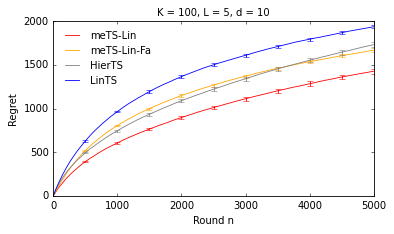

Evaluating meTS 177.2 seconds
Regret: 909.96 +/- 21.67 (median: 909.77, max: 1455.97, min: 594.93)
Evaluating meTSFactored 160.6 seconds
Regret: 989.88 +/- 13.23 (median: 982.18, max: 1178.50, min: 747.70)
Evaluating HierTS 134.9 seconds
Regret: 1077.77 +/- 24.47 (median: 1074.11, max: 1528.56, min: 711.21)
Evaluating LinTS 115.7 seconds
Regret: 1118.15 +/- 10.47 (median: 1127.23, max: 1230.28, min: 955.35)


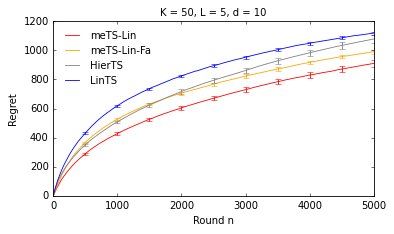

Evaluating meTS 81.3 seconds
Regret: 450.93 +/- 8.98 (median: 443.51, max: 660.41, min: 304.07)
Evaluating meTSFactored 71.8 seconds
Regret: 469.11 +/- 8.44 (median: 465.64, max: 584.88, min: 348.59)
Evaluating HierTS 56.5 seconds
Regret: 541.79 +/- 12.35 (median: 543.51, max: 736.40, min: 318.87)
Evaluating LinTS 49.6 seconds
Regret: 492.80 +/- 6.72 (median: 493.05, max: 614.54, min: 374.40)


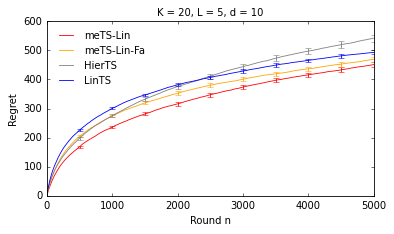

In [11]:
K = 100
L = 5
sigma = 0.5
n = 5000
num_runs = 50

algs = [
  ("meTS", {}, "red", "-", "meTS-Lin"),
  ("meTSFactored", {}, "orange", "-", "meTS-Lin-Fa"),
  ("HierTS", {}, "gray", "-", "HierTS"),
  ("LinUCB", {}, "cyan", "-", "LinUCB"),
  ("LinTS", {}, "blue", "-", "LinTS")]

#exps = [
  #{"K": 100, "L": 5, "d": 2},
  #{"K": 100, "L": 5, "d": 5},
  #{"K": 100, "L": 5, "d": 10},
  #{"K": 50, "L": 5, "d": 2},
  #{"K": 50, "L": 5, "d": 5},
  #{"K": 50, "L": 5, "d": 10},
  #{"K": 20, "L": 5, "d": 2},
  #{"K": 20, "L": 5, "d": 5},
  #{"K": 20, "L": 5, "d": 10},
#]

exps = [
  {"K": 100, "L": 5, "d": 2},
]

for exp in exps:
  # set parameters of the experiment
  for attr, val in exp.items():
    globals()[attr] = val

  # bandit environments
  envs = []
  for run in range(num_runs):
    # contexts are users
    contexts = users[np.random.randint(users.shape[0], size=100), :]
    # arms are movies
    sub = np.random.randint(movies.shape[0], size=K)
    Theta = movies[sub, :]
    
    # cluster movies 
    gm = GaussianMixture(n_components=L, covariance_type='diag').fit(movies)
    # latent parameters are cluster centers
    
    matPsi = gm.means_
    mu_psi = matPsi.flatten()    
    A = gm.predict_proba(Theta)
    
    # arbitrary noise correlation
    Sigma_psi = 0.75 * np.diag(np.tile(var_movie, L)) #block_diag(*[gm.covariances_[l] for l in range(L)]) #0.75 * np.diag(np.tile(var_movie, L))
    Sigma0 = 0.25 * np.tile(np.diag(var_movie), (K, 1, 1)) #np.tile(1e-3 * np.eye(d), (K, 1, 1)) #np.tile(np.diag(var_movie), (K, 1, 1))
    # # independent noise

    mar_Theta0 = np.outer(np.ones(K), mu_movie)
    mar_Sigma0 = np.tile(np.diag(var_movie), (K, 1, 1))

    # initialize bandit environment
    env = CoBandit(K, contexts, Theta, sigma=sigma)

    # pass parameters for algorithm initialization (not used in simulation)
    env.A = A
    env.mu_psi = mu_psi
    env.Sigma_psi = Sigma_psi
    env.Sigma0 = Sigma0
    env.mar_Theta0 = mar_Theta0
    env.mar_Sigma0 = mar_Sigma0

    envs.append(env)

  # simulation
  for alg in algs:
    # all runs for a single algorithm
    alg_class = globals()[alg[0]]
    regret, logs = evaluate(alg_class, alg[1], envs, n)

    # # save results
    #fname = "Results/MovieLens/Linear/%s_K=%d_L=%d_d=%d" % (alg[4], K, L, d)
    #np.save(fname + ".npy", regret)

    # plot
    cum_regret = regret.cumsum(axis=0)
    step = np.arange(1, n + 1)
    sube = (step.size // 10) * np.arange(1, 11) - 1
    plt.plot(step, cum_regret.mean(axis=1),
      alg[2], dashes=linestyle2dashes(alg[3]), label=alg[4])
    plt.errorbar(step[sube], cum_regret[sube, :].mean(axis=1),
      cum_regret[sube, :].std(axis=1) / np.sqrt(cum_regret.shape[1]),
      fmt="none", ecolor=alg[2])

  plt.title("K = %d, L = %d, d = %d" % (K, L, d))
  plt.xlabel("Round n")
  plt.ylabel("Regret")
  plt.ylim(bottom=0)
  plt.legend(loc="upper left", frameon=False)

  plt.tight_layout()
  plt.show()